In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.159195 -0.278713  1.098247  0.605098 -0.357951 -0.775287 -0.592452   
  1   0.277257  0.214213  1.481911 -0.198639 -0.267243 -1.361687  0.239873   
  2  -0.715959  0.106205 -1.209130 -0.965673 -1.671281 -1.541293 -0.913578   
  3  -0.327615  0.555267 -0.072076  0.272042 -0.401068 -0.180763 -0.136587   
  4  -0.718064 -0.039038  0.721883 -0.722617 -0.166538 -0.209791  0.258250   
  5  -0.613036 -0.057615 -0.350878  0.190904 -0.946041 -0.005162  0.553872   
  6   0.331171 -0.013305 -0.141984 -0.264674  0.088236  0.315794 -0.138805   
  7  -0.695222  0.069177 -0.138662 -0.220585 -0.308984 -0.947251  0.126256   
  8   0.738342  0.960363  0.025879  0.667761 -0.662849  0.221865 -0.008435   
  9   0.249206  0.440292  0.213227  0.610834 -0.506087 -0.565710  0.216336   
  10 -0.071155 -0.055188 -0.046924  0.555346 -1.181361 -0.624691  0.088041   
  11  0.271106  0.316015  0.477670 -0.209210 -0.777854 -0.841503  0.147118   
  12  0.459195  0.838068  0.015688  0.348630  0.350344 -1.034582  0.675720   
  13 -0.081223  0.607695  0.917332 -0.390544  0.323078 -1.392015  0.050997   
  14 -0.183997 -0.559264 -0.825798  0.625542  0.117551 -0.443081 -0.272735   
  15  0.132364 -0.314817 -0.063932  0.274996 -0.293746 -0.553720 -0.356412   
  16  0.410669 -0.265392 -0.139910 -0.110844  0.630162  0.188925  0.583057   
  17  0.063590  0.518682  0.012566  0.063702 -0.351301 -1.269638  0.055170   
  18 -1.320417 -0.095511  0.116887  0.011752 -0.682386 -1.542916 -1.355140   
  19 -0.149609 -0.383209  0.230169 -0.007548 -0.078401 -0.487822  0.820234   
  20  1.220064  0.378053 -0.132811 -0.950084 -0.886422 -0.136895 -0.373441   
  21  0.712117  0.650443  0.159347  0.024989 -0.127036 -0.058904  1.005819   
  22  0.020171  0.723502  0.424246  0.788345  1.088751  0.018209 -0.300529   
  23  0.226015  0.449635 -0.162723  0.200064  0.436882 -0.040453  0.984343   
  24 -0.222424  0.184731  0.077573 -0.307731 -0.227670 -1.293446  0.556096   
1 0  -0.359046 -0.043923 -0.536363  0.713300  0.633500 -0.027086  0.843137   
  1   0.228453  0.054533  0.080485  0.016816  0.051900 -0.572223 -0.144287   
  2  -0.054792 -0.289909  0.286332  0.276520  0.181269 -0.467469 -0.019634   
  3  -0.497892  0.517581  0.676967 -0.555374 -0.385144  0.104466 -0.146338   
  4  -0.909507 -0.200059 -0.252409 -0.453495 -0.236662  0.494150  1.096740   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.248722  0.409787 -1.238529  ... -0.478002 -0.002180 -0.625664   
  1   0.079430  0.254715 -0.338012  ... -0.298975 -0.848430  0.130902   
  2   0.467954  2.176417  0.773856  ... -0.254415  0.414341  0.434749   
  3  -0.344864 -0.588551  0.213609  ... -0.456134 -0.934468  0.675657   
  4   0.300460  0.222336  0.849543  ... -0.026570 -0.744251 -0.724422   
  5   1.197209  0.966421 -0.010801  ... -1.041324 -0.329990 -0.920182   
  6   0.410637  1.661515  0.858254  ... -0.641158  0.339365 -0.912980   
  7   0.975560 -0.526812 -0.924322  ... -0.052957 -0.554234 -0.829167   
  8  -0.561055  1.469325  1.133269  ... -1.352038  0.003479 -0.862751   
  9   0.414938  0.541059 -0.759390  ...  0.138536  0.540379 -0.425908   
  10 -0.034236  0.182905  0.354626  ... -0.763868 -0.590709  0.143693   
  11  0.016308 -0.558226 -0.160918  ...  0.168473 -0.250820  0.193859   
  12  1.088394  0.760319 -0.478139  ... -0.832504 -0.633348  0.346576   
  13  0.223646  1.566453 -0.032130  ... -0.125651 -0.289469 -0.016973   
  14  0.368142  0.774660  0.972944  ... -0.130018  0.282264 -0.403938   
  15  0.339244  0.885478 -0.025809  ... -0.678021 -0.512665 -0.180171   
  16  1.195305  1.054166  0.559949  ... -0.847151  0.175621 -0.536534   
  17  0.124428 -0.485787  0.184701  ... -0.573370 -0.476942 -0.609942   
  18 -1.013611  0.541733 -0.195248  ... -0.688377  0.353260  0.533231   
  19  0.443811  1.431410  0.868217  ... -0.243591  0.257929 -0.211566   
  20  0.895525  0.025885  0.487524  ... -0.519004 -0.669028 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err         t          P>|t|     2.5 %    97.5 %
D  1.079342  0.047952  22.50865  3.415122e-112  0.985357  1.173327


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



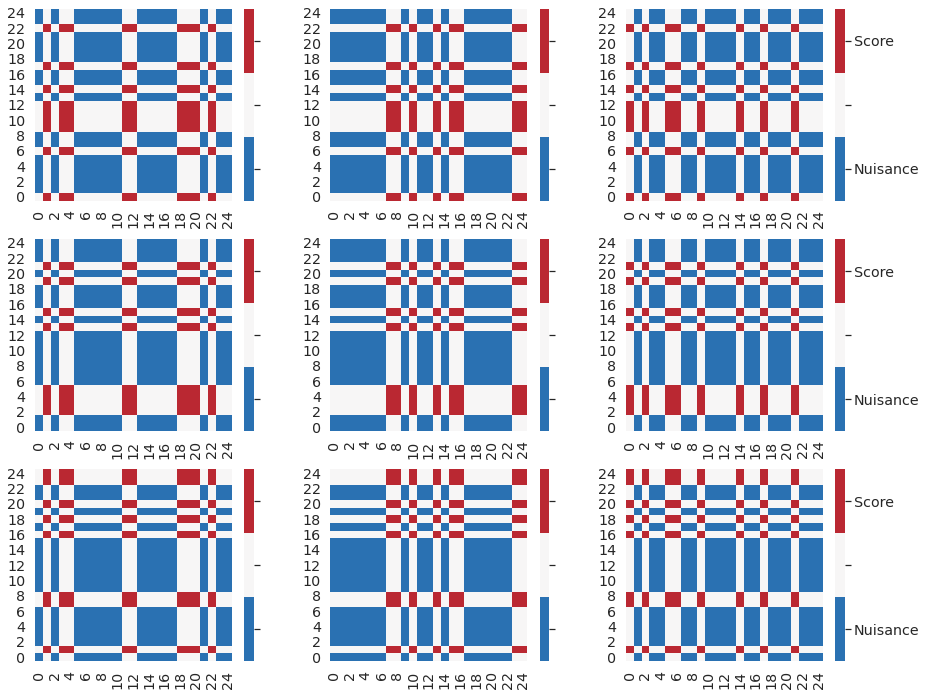

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



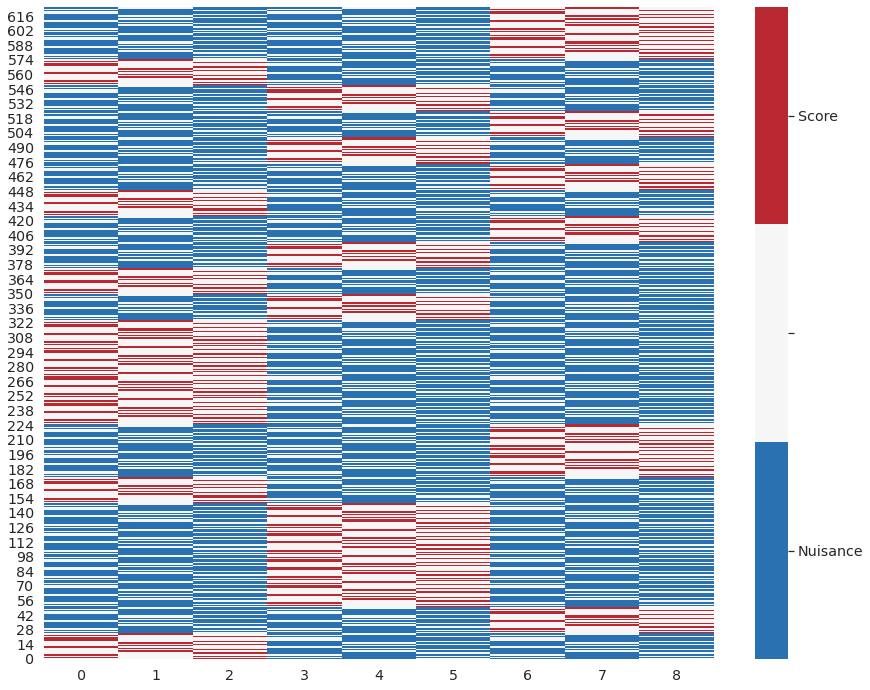

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])